In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch import Tensor
import torch.nn.functional as F
import pdb
import math
from torch.optim.lr_scheduler import LambdaLR

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Tensor

torch.cuda.FloatTensor

In [4]:
torch.manual_seed=(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Step 1: Load Dataset

Let's load MNIST dataset

In [5]:
train_dataset = datasets.MNIST(root='./mnist_data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./mnist_data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15219943.64it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 444694.58it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3948591.79it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8706823.02it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [6]:
batch_size = 100
num_epochs = 10

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Step 2: LSTM cell implementation

In [8]:
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
    self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self):
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    hx, cx = hidden

    x = x.view(-1, x.size(1))

    gates = self.x2h(x) + self.h2h(hx)
    gates = gates.squeeze()

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    forgetgate = F.sigmoid(forgetgate) # Forget
    ingate = F.sigmoid(ingate) # Update
    cellgate = F.tanh(cellgate) # tanh
    outgate = F.sigmoid(outgate) # output

    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
    hy = torch.mul(outgate, F.tanh(cy))

    return (hy, cy)

# Step 3: Create Model Class

In [9]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim
    self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # Init hidden states
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

    # Init cell states
    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

    outs = []

    cn = c0[0,:,:]
    hn = h0[0,:,:]

    for seq in range(x.size(1)):
      hn, cn = self.lstm(x[:,seq,:], (hn, cn))
      outs.append(hn)

    out = outs[-1].squeeze()
    out = self.fc(out)

    return out

# Step 4: Init model Class

In [10]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

LSTMModel(
  (lstm): LSTMCell(
    (x2h): Linear(in_features=28, out_features=512, bias=True)
    (h2h): Linear(in_features=128, out_features=512, bias=True)
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
lossfn = nn.CrossEntropyLoss()
learning_rate = 0.1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = LambdaLR(optim, lr_lambda=lambda epoch: 0.95 ** epoch)

# Step 5: Train

In [12]:
def checkAcc():
  correct = 0
  total = 0

  for images, labels in test_loader:
    images = images.view(-1, seq_dim, input_dim).to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

  return 100 * correct / total

In [13]:
seq_dim = 28
loss_list = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1, seq_dim, input_dim).to(device)
    labels = labels.to(device)

    # Clear gradients
    optim.zero_grad()

    # Forward pass
    output = model(images)

    # Calculate loss
    loss = lossfn(output, labels)

    # Backward pass
    loss.backward()

    # Update parameters
    optim.step()

    loss_list.append(loss.item())

  acc = checkAcc()
  print('epoch {}/{}. Loss: {}. ACC: {}'.format(epoch+1, num_epochs, loss.item(), acc))

  scheduler.step()

epoch 1/10. Loss: 2.1300947666168213. ACC: 24.1299991607666
epoch 2/10. Loss: 0.6652718186378479. ACC: 77.54999542236328
epoch 3/10. Loss: 0.34333038330078125. ACC: 90.19999694824219
epoch 4/10. Loss: 0.32344990968704224. ACC: 94.25
epoch 5/10. Loss: 0.37173813581466675. ACC: 94.7699966430664
epoch 6/10. Loss: 0.16258786618709564. ACC: 95.8699951171875
epoch 7/10. Loss: 0.11503539234399796. ACC: 96.62999725341797
epoch 8/10. Loss: 0.045136112719774246. ACC: 97.04999542236328
epoch 9/10. Loss: 0.14211852848529816. ACC: 97.18000030517578
epoch 10/10. Loss: 0.24897977709770203. ACC: 97.33999633789062


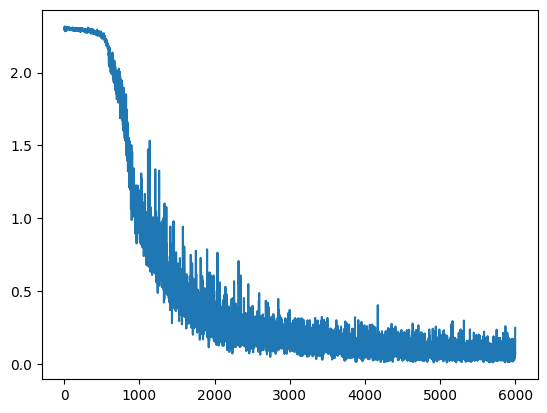

In [14]:
# Loss graph
plt.plot(loss_list)
plt.show()

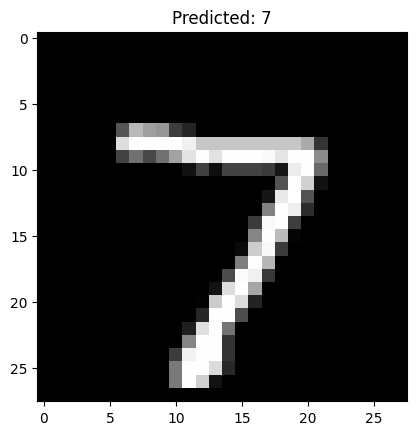

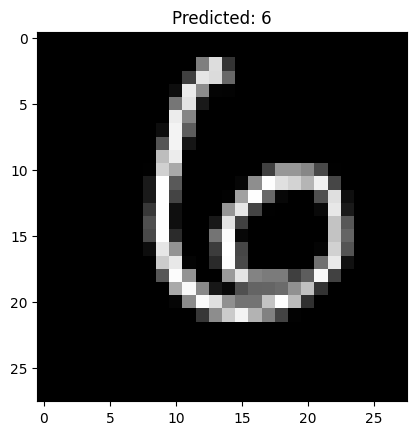

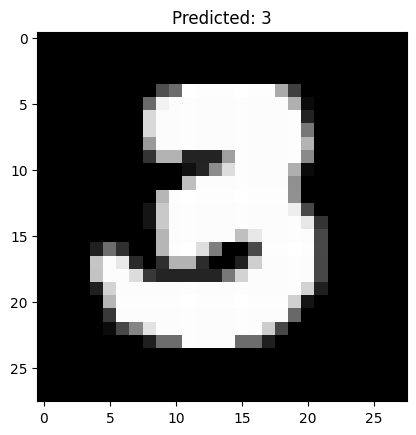

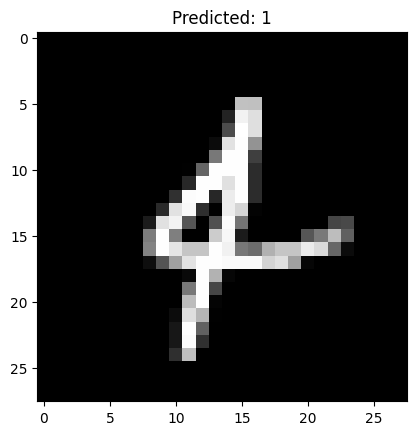

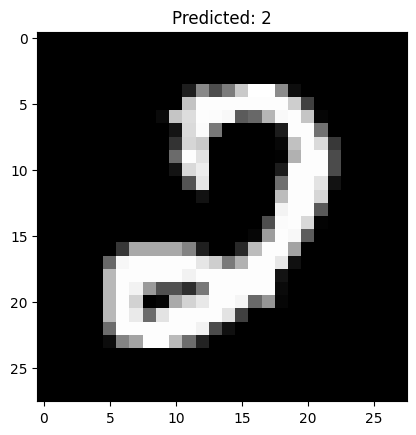

In [15]:
# Show img
iter = 0
for images, labels in test_loader:
  images = images.view(-1, seq_dim, input_dim).to(device)
  labels = labels.to(device)

  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)

  plt.imshow(images[0].cpu().detach().numpy().reshape(28, 28), cmap='gray')
  plt.title('Predicted: {}'.format(predicted[0].item()))
  plt.show()
  iter += 1
  if iter == 5:
    break